In [1]:
# load in the correct modules
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm
import cmasher as cm
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import warnings
warnings.filterwarnings('ignore')
import jax
from scipy import stats
import matplotlib.gridspec as grid
from matplotlib.colors import LogNorm

In [2]:
# LOAD THE DATA
path = '/Users/dhortadarrington/Documents/Master/data/allstar-dr17-StarHorse-Gaiadr3'
tb = fits.open(path)
data = tb[1].data 

# LOAD THE DATA FOR THE GC LIST IN APOGEE
path = '/Users/dhortadarrington/Documents/Master/data/'
file = 'GC_catalogo_14_mayo.fits'
# file = 'GC_DR16plus_nofeh.fits'

tb2 = fits.open(path+file)
data2 = tb2[1].data
gc_star_ids = data2.field('APOGEE_ID')
print('There are '+str(len(gc_star_ids))+' GC stars')

# LOAD THE DATA FOR THE GC LIST IN APOGEE
path = '/Users/dhortadarrington/Documents/Master/data/'
file = 'VAC_GC_DR17_synspec_rev1_beta.fits'
# file = 'GC_DR16plus_nofeh.fits'

tb3 = fits.open(path+file)
data3 = tb3[1].data
gc_star_ids_RPS = data3.field('APOGEE_ID')
print('There are '+str(len(gc_star_ids_RPS))+' GC stars')

apo_id = data['APOGEE_ID']
# Clean the initial data
mask_gcs = np.isin(list(apo_id),list(gc_star_ids))
mask_gcs2 = np.isin(list(apo_id),list(gc_star_ids_RPS))

There are 7562 GC stars
There are 7737 GC stars


In [3]:
starflag_bits = np.array(
    [
        0,  # BAD_PIXELS
        1,  # COMMISSIONING
        3,  # VERY_BRIGHT_NEIGHBOR
        16,  # SUSPECT_RV_COMBINATION
        17,  # SUSPECT_BROAD_LINES
        19,  # RV_REJECT
        21,  # MULTIPLE_SUSPECT
        22,  # RV_FAIL
    ]
)
starflag_bitmask = np.sum(2**starflag_bits)
starflag_mask = (data["STARFLAG"] & starflag_bitmask) == 0
starflag_mask.sum()

aspcapflag_bits = np.array(
    [
        23,  # STAR_BAD
    ]
)
aspcapflag_bitmask = np.sum(2**aspcapflag_bits)
aspcapflag_mask = (data["ASPCAPFLAG"] & aspcapflag_bitmask) == 0
aspcapflag_mask.sum()

536568

In [4]:
# create the parent mask
mask = (data['SNR']>50)&(data['LOGG']<3.5)&(data['LOGG']>1.)&(data['TEFF']>3500.)&(data['TEFF']<5500.)\
    &(mask_gcs==False)&(mask_gcs2==False)&(starflag_mask)&(aspcapflag_mask)&(data['ruwe']<1.4)&\
    (data['parallax']>0.2)&(data['parallax_over_error']>8.)

print('There are '+str(len(data[mask]))+' stars in the parent sample')


There are 174274 stars in the parent sample


# Loop over one action and plot the other two with chemical gradients

In [6]:
def plot_xfe_actions(xfe,jx,jy,jz,jphi_sun,mask,n=10,nbins=20,cmap=cm.pride,stat='mean'):

    # loop over the abundances
    
    for indx, i in enumerate(xfe):
        
        xfe_labels = ['[Mg/Fe]','[Al/Fe]','[Ni/Fe]','[(C+N)/Fe]','[Ce/Fe]','[Fe/H]']
        vmins = [0.,-0.05,-0.05,-0.05,-0.2,-0.6]
        vmaxs = [0.2,0.15,0.05,0.05,0.2,0.2]

        
        xfe2 = i[mask]
        jx2 = jx[mask]
        jy2 = jy[mask]
        jz2 = jz[mask]
        # here we are in the space of [X/Fe] for all stars in our sample. We will now split the samples in n 
        # equal parts in a dimension of Jx (i.e., actions) and then plot chemical gradient of those stars in the other
        # orthogonal pair of actions (i.e., Jy, Jz)
        
        # we will split the range of dimension j (which here is jx) into n equal overlapping sections,
        # for now we will use n=9 to get 8 equal sections
        xs = np.around(np.linspace(np.min(jx2),np.max(jx2),n),decimals=2)
        
        # create the plot
        fig, all_axes = plt.subplots(len(xfe),len(xs), constrained_layout=True, figsize=(25, 5), sharex=True, sharey=True,rasterized=True)

        axis = all_axes[indx]

        for indx2, k in enumerate(xs[:-1]):
            ax = axis[indx]
            # create a mask for every loop
            if k<xs[-2]:
                mask_loop = (jx2>k)&(jx2<xs[indx2+2])&(xfe2>-10)
                # make the plot

                binx = np.linspace(np.min(jy2/jphi_sun),np.max(jy2/jphi_sun),nbins)
                biny = np.linspace(np.min(jz2/jphi_sun),np.max(jz2/jphi_sun),nbins)
                hist = stats.binned_statistic_2d(jy2[mask_loop]/jphi_sun,jz2[mask_loop]/jphi_sun, xfe2[mask_loop], statistic=stat, bins=[binx,biny])
                plot_x, plot_y = np.meshgrid(binx,biny) 
                color = ax.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cmap,vmin=0.,vmax=0.12)            
                
                ax.set_xlim(np.min(jy2/jphi_sun),np.max(jy2/jphi_sun))
                ax.set_ylim(np.min(jz2/jphi_sun),np.max(jz2/jphi_sun))
                # ax.text(1,-0.3,str(int(np.sum(nstars_summed[indx]))),fontsize=22)
                ax.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=14)
#                 ax.text(1.6,0.4,r'N$_{\mathrm{stars}}$ '+str(len(jy2[mask_loop])),fontsize=14)
                
            else:
                pass
#         cbar_ax = fig.add_axes([0.4, 0.92, 0.06,0.006])
#         cbar = fig.colorbar(color, cax = cbar_ax,orientation='horizontal')
#         cbar.set_label(label=xfe_labels[indx],fontsize=18)
#         cbar.ax.tick_params(labelsize=18)

#         axis[0].set_title(r'' +str('%5.2f' %xs[0])+ r'$<$J$_{R} [kpc km/s]$$<$ '+str('%5.2f' %xs[2]),fontsize=18)
#         axis[1].set_title(r'' +str('%5.2f' %xs[1])+ r'$<$J$_{R} [kpc km/s]$$<$ '+str('%5.2f' %xs[3]),fontsize=18)
#         axis[2].set_title(r'' +str('%5.2f' %xs[2])+ r'$<$J$_{R} [kpc km/s]$$<$ '+str('%5.2f' %xs[4]),fontsize=18)
#         axis[3].set_title(r'' +str('%5.2f' %xs[3])+ r'$<$J$_{R} [kpc km/s]$$<$ '+str('%5.2f' %xs[5]),fontsize=18)

#         axis[0].set_ylabel('J$_{z}$/J$_{\phi,\odot}$',fontsize=20)
#         axis[0].set_xlabel('J$_{\phi}$/J$_{\phi,\odot}$',fontsize=20)
#         axis[1].set_ylabel('J$_{z}$/J$_{\phi,\odot}$',fontsize=20)
#         axis[1].set_xlabel('J$_{\phi}$/J$_{\phi,\odot}$',fontsize=20)
#         axis[2].set_ylabel('J$_{z}$/J$_{\phi,\odot}$',fontsize=20)
#         axis[2].set_xlabel('J$_{\phi}$/J$_{\phi,\odot}$',fontsize=20)        
#         axis[3].set_ylabel('J$_{z}$/J$_{\phi,\odot}$',fontsize=20)
#         axis[3].set_xlabel('J$_{\phi}$/J$_{\phi,\odot}$',fontsize=20)
#         plt.savefig('../plots/lowa_jphi_jz'+str(xfe_names[indx]),dpi=150,format='png', rasterized=True)
    

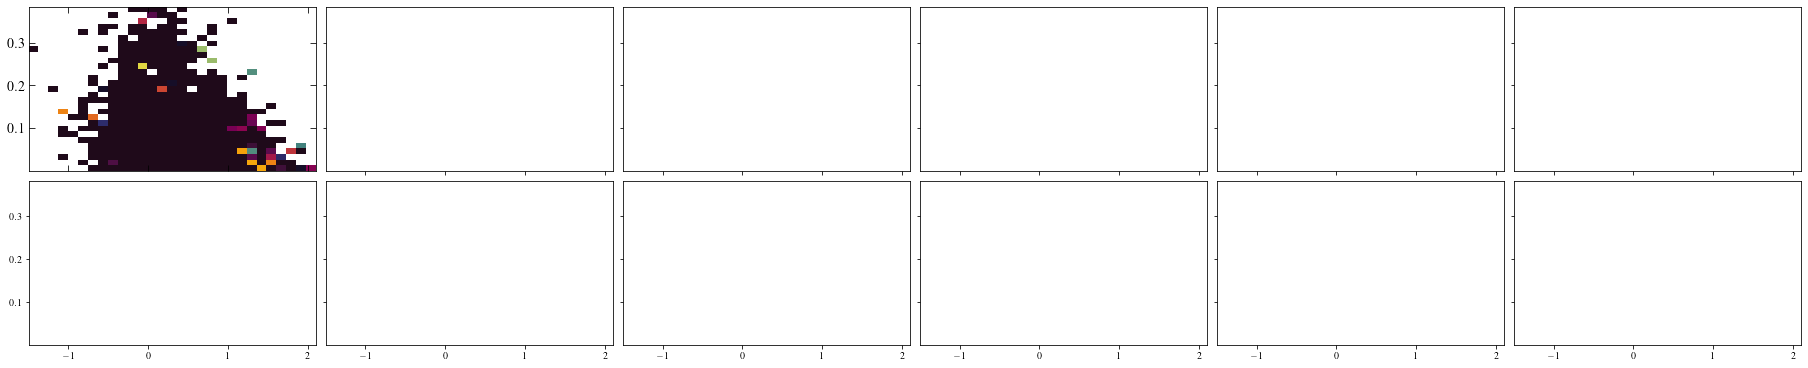

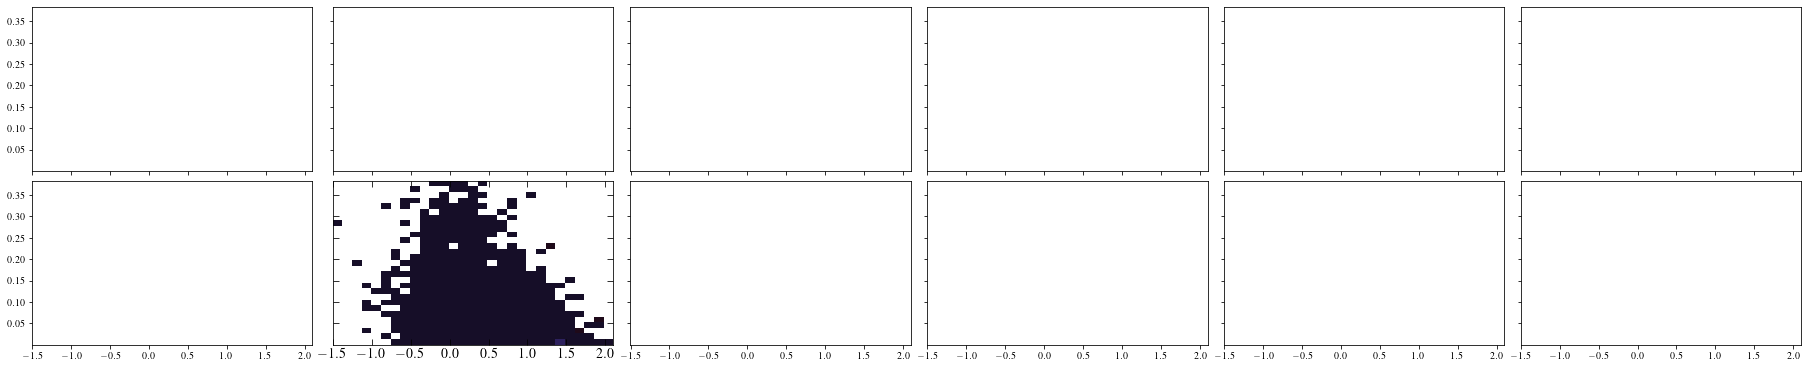

In [7]:
# xfe=np.dstack([data['MG_FE'],data['AL_FE'],data['NI_FE'],data['CE_FE'],data['FE_H']])[0].T
xfe=np.dstack([data['MG_FE'],data['FE_H']])[0].T

jphi_sun = 8.275*251.8
jr = data['actions'][:,0]
jphi = -data['L'][:,2]
jz = data['actions'][:,2]

omask = (jr>0)&(jr<800)&(np.fabs(jphi)<5000)&(jz>0)&(jz<800)

plot_xfe_actions(xfe,jr,jphi,jz,jphi_sun,mask&omask,nbins=30,n=6,cmap=cm.pride)


(array([133378.,  25569.,   6876.,   2725.,   1412.,    869.,    631.,
           483.,    345.,    242.]),
 array([6.37913573e-04, 7.99572828e+01, 1.59913928e+02, 2.39870572e+02,
        3.19827217e+02, 3.99783862e+02, 4.79740507e+02, 5.59697152e+02,
        6.39653797e+02, 7.19610441e+02, 7.99567086e+02]),
 <BarContainer object of 10 artists>)

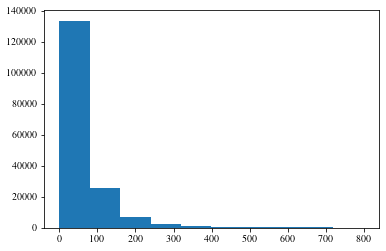

In [48]:
plt.hist(jr[mask&omask])